# Aqua 0.7: Qiskit Chemistry Re-Design Doc

| **Status**        | **Accepted** |
|:------------------|:---------------------------------------------|
| **RFC #**         | 0001                                         |
| **Authors**       | Panos, Donny, Steve, Ivano                   |
| **Submitted**     | 2020-01-06                                   |
| **Updated**       | 2020-01-24                                   |

## Purpose

To define a hierarchical and Pythonic interface for Chemistry Quantum Algorithms & Applications (QA&A) research computation in Qiskit. Specifically, we define Chemistry to be the computation of electronic and thermodynamic observables.

## Background

* Qiskit Chemistry is a widely used library today for a core set of Chemistry (QA&A) tasks. It was rapidly built to be able to execute this core set of tasks, but now is moving into a stage where it requires more flexibility and extensibility.
* The core activity in Qiskit Chemistry today is the computation of molecular ground state energies, usually with VQE and often UCCSD. Other core features include interfacing with classical software to compute electronic structure observables, mapping fermionic operators to qubit operators in various ways, tapering symmetries from qubit operators, and computing excited states with the EOM.

## Core Features and Object Model

We've divided the Chemistry stack in four core areas, and introduced the concept of an _application_ (shown italicised below):

* Electronic Structure
    * _GroundStateEnergy_, ExcitedStates (EOM), electronic structure observables
* Vibronic Structure
    * _VibrationalModes_ (inc. Vibrational Frequencies), Nuclear Wavefunction
* Thermodynamics
    * _Partition Function_, Thermodynamic Observables
* Molecular Dynamics (after 0.7 release) 

Core objects:
* Molecule - Contains geometry, basis, degrees of freedom, other info (mass, charge, spin, etc.).
* Driver - Interface object with classical software to compute electronic structure observables.
* FermionicOperator - Constructed from Physics stack tools.
* Applications - Convenient end to end interfaces for complete computations.

## Demo

In [2]:
from functools import partial
import numpy as np
import matplotlib.pyplot as plt

from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.chemistry.GSE import GroundStateEnergy
from qiskit.chemistry.molecule import Molecule
from qiskit.aqua.components.variational_forms import RY
from qiskit.aqua.components.optimizers import SLSQP
from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms import VQE, ExactEigensolver
from qiskit import Aer

In [3]:
stretch = partial(Molecule.absolute_distance, atom_pair=(1, 0))
# H-H molecule near equilibrium geometry
m = Molecule(geometry=[['H', [0., 0., 0.]],
                       ['H', [1., 0., 0.]],
                       ],
             degrees_of_freedom=[stretch],
             masses = [1.6735328E-27, 1.6735328E-27],
             tapering=True)
# Note - Driver not passed here for quick hacking, but PySCF hardcoded underneath.

In [ ]:
# Some old code for easy hacking compatibility

qubitop = m.get_qubitop_hamiltonian([1])
core = m.hamiltonian

hf = HartreeFock(num_qubits=qubitop.num_qubits,
                      num_orbitals=core._molecule_info['num_orbitals'],
                      qubit_mapping=core._qubit_mapping,
                      two_qubit_reduction=core._two_qubit_reduction,
                      num_particles=core._molecule_info['num_particles'],
                      sq_list=m.sq_list
                      )
ry = RY(qubitop.num_qubits, depth=1, entangler_map=None,
              entanglement='full', initial_state=hf,
              entanglement_gate='cz', skip_unentangled_qubits=False)

In [ ]:
backend = QuantumInstance(Aer.get_backend('statevector_simulator'), shots=1)
backend.run_config.seed_simulator = 50
backend.compile_config['seed_transpiler'] = 50

vqe = VQE(operator=None, var_form=ry, optimizer=SLSQP())
gse = GroundStateEnergy(molecule=m, min_eigensolver=vqe, backend=backend)

points = np.arange(.2, 3.0, .1)
results = gse.compute_ground_state_energy(points)

for point, res in results.items():
    print(res['energy'])

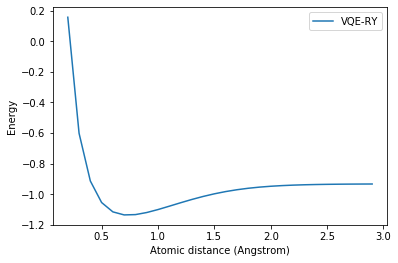

In [7]:
energies = [res['energy'] for res in results.values()]
plt.plot(points, energies, label='VQE-RY')
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.legend()
plt.show()